# Introduction

The purpose of this project is to develop an artificial intelligence (AI) that (e.g., from mobile users) assigns tasks to servers (e.g., edge servers). The tasks and servers are distributed geographically over some region, e.g., EMEA. We can only assign a task to a server when the task is within the server's reach (see Figure below). Tasks spawn randomly and have a fixed workload. The servers also appear randomly and stay online for a duration that is uncertain. The AI comprises predictive as well as prescriptive components. A machine learning algorithm predicts the time until resources go offline, and that prediction is used in the heuristic that makes the assignments. An event-based simulation evaluates the performance of the AI supplying several KPIs.



![title](../documentation/tasks-and-servers.jpg)


### Resources

* The region is divided into sub-regions.
* Resources spawn in each region according to a specific Poisson process.
* When a resource goes offline and a task is currently being processed, the progress is lost, and the task is dispatched again.
* A resource can do one task at a time.

### Tasks

* Tasks spawn in each region according to a specific Poisson process.
* Each task has a workload that becomes known at the time the task is created.
* Each task has a deadline that is unknown to the servers and the assignment algorithm.
* When a task is not processed before the deadline, the task is considered failed, and it is removed from the system.



# Imports

In [3]:
import math
from collections import namedtuple
from dataclasses import dataclass, field
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydeck as pdk
import simpy as sp
from scipy.stats import uniform, triang, expon
from shapely.geometry import Point

# Helper functions

In [3]:


EPS = 1e-4  # Numerical value for zero to deal with floating point errors


def distance_haversine(p1: Point, p2: Point) -> float:
    """
    Return the Haversine distance in km.
    :param p1: 1st coordinate corresponds to longitude, 2nd to latitude.
    :param p2: same.
    """
    if p1 == p2:
        return 0.0

    v = (math.sin(p1.y * math.pi / 180) * math.sin(p2.y * math.pi / 180)
         + math.cos(p1.y * math.pi / 180) * math.cos(p2.y * math.pi / 180)
         * math.cos(p2.x * math.pi / 180 - p1.x * math.pi / 180))

    # take care of floating point imprecision
    if 1 < v < 1 + EPS:
        v = 1.0
    elif -1 - EPS < v < -1:
        v = -1.0

    if v < -1 or v > 1:
        raise RuntimeError(f'Unexpected error in distance for {p1}, {p2})')

    return 1.852001 * 3443.8985 * math.acos(v)


@dataclass
class MyEnv:
    env: sp.Environment
    out: bool = False  # Flag to turn simulation output to the console on/off
    log: bool = False  # Flag to turn simulation logging on/off
    logs: list[str] = field(default_factory=list)


def sim_print_msg(env: MyEnv, event_name, msg=None):
    if msg is None:
        return f"{env.env.now:3.0f}; {event_name:15}"
    else:
        return f"{env.env.now:3.0f}; {event_name:15}; {msg}"

    
def sim_print(env: MyEnv, event_name, msg=None):
    """
    Print function for use in the simulation that allways prints the simulation time and
    allows to switch off the output. 
    
    The output can be supressed by setting the flag environment.out to False when running the simulation.
    
    """
    if env.out:
        print(sim_print_msg(env, event_name, msg=msg))
    if env.log:
        env.logs.append(sim_print_msg(env, event_name, msg=msg))


def sample_location_in_rectangular_region(region):
    """
    Return a random point within the provided rectangular region.
    :param region: a rectangular region
    """
    return Point(region.left_bottom.x + uniform.rvs() * (region.right_top.x - region.left_bottom.x),
                 region.left_bottom.y + uniform.rvs() * (region.right_top.y - region.left_bottom.y))


class StepFunction:

    def __init__(self, xs, ys):
        """
        :param xs: the x-values where the function makes a jump.
        :param ys: the levels for all x-values but the last one.
        """
        assert len(xs) == len(ys) + 1
        self.xs = xs
        self.ys = ys

    def append_step(self, x, y, x_end=None):
        """
        Add another bar to the end of the function.
        """
        self.xs.pop()
        self.xs.append(x)
        self.ys.append(y)
        if x_end is None:
            self.xs.append(x)
        else:
            self.xs.append(x_end)

    def get_area(self):
        """
        Gets the area under the step-function.
        """
        ret = 0
        for idx, x in enumerate(self.xs[1:]):
            ret += self.ys[idx] * (x - self.xs[idx])
        return ret

    def get_average(self):
        return self.get_area() / (self.xs[-1] - self.xs[0])

    def plot(self, title=None):
        xx = self.xs[0:1] + reduce(lambda i, j: i + [j, j], self.xs[1:-1], []) + self.xs[-1:]
        yy = reduce(lambda i, j: i + [j, j], self.ys, [])
        plt.plot(xx, yy)
        plt.axhline(self.get_average())
        if title is not None:
            plt.title(title)
        plt.show()


# Data import and analysis

Each row of the dataset represents a period in which a resource is active. The user IDs are the IDs of the resources. They are not unique because the same resource can be active multiple times.

In [1]:
df = pd.read_csv("data.csv")
df = df.drop("Unnamed: 0", axis=1)
print(df.shape)
df['start time'] = pd.to_datetime(df['start time'], format="%m/%d/%Y %H:%M")
df['end time'] = pd.to_datetime(df['end time'], format="%m/%d/%Y %H:%M")
df.head()

NameError: name 'pd' is not defined

## Resources

In [2]:
print("Average number of appearances per resource:", df.shape[0] / len(df['user id'].unique()))

NameError: name 'df' is not defined

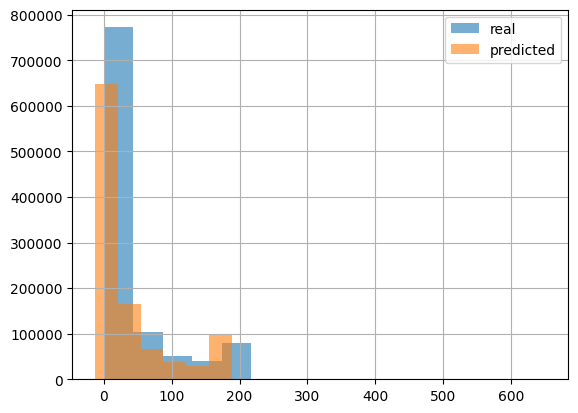

In [6]:
df["user_availability"].hist(bins=15, alpha=0.6)
df["pred_user_availability"].hist(bins=15, alpha=0.6)
plt.legend(["real", "predicted"])
plt.show()

In [7]:
print("Lowest prediction of duration of availability:", df["pred_user_availability"].min())

Lowest prediction of duration of availability: -13.21471


**The rows with non-positive predictions are dropped!**

In [8]:
n = df.shape[0]
df = df.loc[df["pred_user_availability"] > EPS, :]
print(f"Dropped {n - df.shape[0]} rows")

Dropped 2057 rows


## Geography

In [9]:
lon_min = df['longitude'].min()
lon_max = df['longitude'].max()
lat_min = df['latitude'].min()
lat_max = df['latitude'].max()
lat_q_low, lat_q_high = np.quantile(df['latitude'], q=[0.05, 0.95])
lon_q_low, lon_q_high = np.quantile(df['longitude'], q=[0.05, 0.95])

print(f"lon stats: {lon_min:.2f}, {lon_q_low:.2f}, {lon_q_high:.2f}, {lon_max:.2f}")
print(f"lat stats: {lat_min:.2f}, {lat_q_low:.2f}, {lat_q_high:.2f}, {lat_max:.2f}")

lon stats: 102.00, 121.18, 121.67, 131.81
lat stats: 22.52, 30.90, 31.38, 47.35


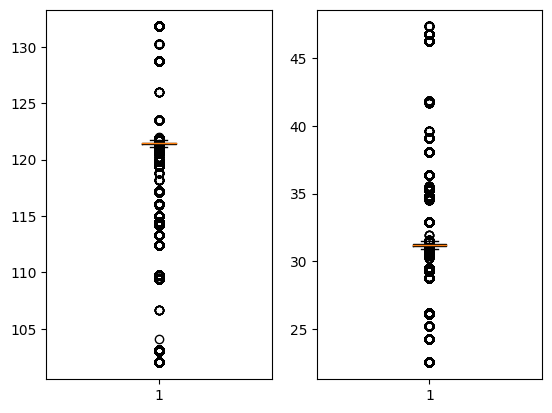

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(df['longitude'])
ax2.boxplot(df['latitude'])
plt.show()

=> The geographical distribution of tasks is very skewed!

Visualize the geographic region.

* Get a rectangular boundary of the entire region defined by the left bottom point and right top point, and
* Prepare a dataframe to diplay the rectangular boundary on a map.

In [11]:
df_extreme_points = pd.DataFrame({
    "longitude": [lon_min, lon_min, lon_max, lon_max],
    "latitude": [lat_min, lat_max, lat_max, lat_min],
})
print(df_extreme_points.head(2))

df_extreme_points["idx"] = df_extreme_points.index
df_extreme_points["idx_next"] = (df_extreme_points.index - 1) % df_extreme_points.shape[0]
df_box = df_extreme_points.merge(
    df_extreme_points, 
    left_on="idx", right_on="idx_next", 
    suffixes=('_start', '_dest'))
df_box = df_box[["longitude_start", "latitude_start", "longitude_dest", "latitude_dest"]]
print(df_box.head(2))

    longitude   latitude
0  102.003965  22.522803
1  102.003965  47.350920
   longitude_start  latitude_start  longitude_dest  latitude_dest
0       102.003965       22.522803      102.003965       47.35092
1       102.003965       47.350920      131.812182       47.35092


Create a map in html to be viewn in the browser.

In [12]:
df_subset = df.sample(n=100000)
df_subset = df_subset.loc[:, ["latitude", "longitude"]]
df_subset["outlier"] = False
mask_lon = (df_subset["longitude"] < lon_q_low) | (df_subset["longitude"] > lon_q_high)
mask_lat = (df_subset["latitude"] < lat_q_low) | (df_subset["latitude"] > lat_q_high)
df_subset.loc[mask_lon | mask_lat, "outlier"] = True

view_state = pdk.ViewState(longitude=df['longitude'].mean(), latitude=df['latitude'].mean(), zoom=3.5)

location_layer = pdk.Layer(
    'ScatterplotLayer',
    df_subset,
    pickable=True,
    opacity=0.8,
    stroked=True,
    filled=True,
    radius_scale=6,
    radius_min_pixels=4,
    radius_max_pixels=100,
    get_position=['longitude', 'latitude'],
    get_fill_color="outlier ? [251, 101, 66] : [255, 187, 0]")

extreme_point_layer = pdk.Layer(
    "ScatterplotLayer",
    df_extreme_points,
    pickable=False,
    opacity=1,
    stroked=True,
    filled=True,
    radius_scale=20,
    radius_min_pixels=10,
    radius_max_pixels=100,
    get_position=['longitude', 'latitude'],
    get_fill_color=[55, 94, 151])

line_layer = pdk.Layer(
    "LineLayer",
    df_box,
    get_source_position=["longitude_start", "latitude_start"],
    get_target_position=["longitude_dest", "latitude_dest"],
    get_width=10,
    get_color=[55, 94, 151],
    picking_radius=10,
    auto_highlight=True,
    pickable=True)

deck = pdk.Deck(layers=[location_layer, extreme_point_layer, line_layer], initial_view_state=view_state)
deck.to_html("locations.html")
print("Open html file to see map! Might load slow.")

Open html file to see map! Might load slow.


## Timing

Check if the arrival rate of resources is stable.

<AxesSubplot: >

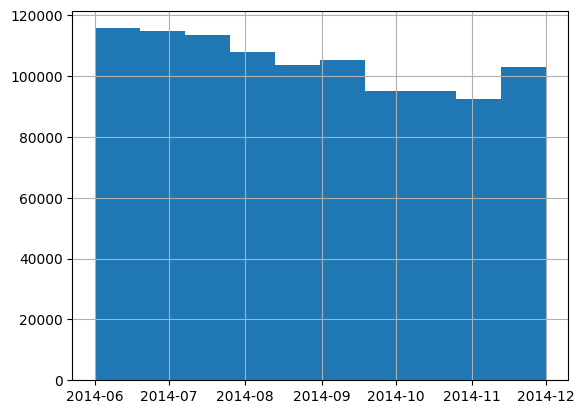

In [13]:
df['start time'].hist()

Arrival rate of resources seems to be approximately level over time.
The dataset covers about 6 month.

In [14]:
period_length = df["start time"].max() - df["start time"].min()
print("Total horizon:", period_length)

Total horizon: 183 days 00:49:00


# Types

Define the data types needed in the simulation.

In [15]:
Region = namedtuple("Region", ["id", "left_bottom", "right_top"])


class Resource:
    def __init__(self, id, state, location, region, date_created, actual_lifetime_end, forecast_lifetime_end):
        self.id = id
        self.state = state
        self.location = location
        self.region = region
        self.date_created = date_created
        self.actual_lifetime_end = actual_lifetime_end
        self.forecast_lifetime_end = forecast_lifetime_end

        # Attributes to keep track of the assigned tasks
        self.assigned_tasks = []
        self.date_started = []
        self.date_finished = []

    def __repr__(self):
        return f"Resource [{self.id},state={self.state},region={self.region.id},"f"created={self.date_created:.0f},end={self.actual_lifetime_end:.0f},"f"est_end={self.forecast_lifetime_end:.0f}]"


class Task:
    def __init__(self, id, location, region, date_created, duration, forecast_duration, deadline):
        self.id = id
        self.state = "waiting"
        self.location = location
        self.region = region
        self.date_created = date_created
        self.duration = duration
        self.forecast_duration = forecast_duration
        self.deadline = deadline

        # Attributes to keep track of assigned resources
        # Lists are required because a task can fail and be assigned to multiple resources
        self.assigned_resources = []
        self.date_started = []
        self.date_finished = []
        self.num_interruptions = 0

    def __repr__(self):
        return f"Task [{self.id},state={self.state},region={self.region.id},"f"created={self.date_created:.0f},"f"duration={self.duration:.0f},"f"est_duration={self.forecast_duration:.0f},"f"deadline={self.deadline:.0f}]"

    def has_been_interrupted(self):
        """Called after the simulation to find out if the task has been interrupted."""
        return self.num_interruptions > 0

    def total_waiting_time(self, sim_end_time):
        """Called after the simulation to get the waiting time."""
        if not self.date_started:  # never started => waited till deadline or end of simulation
            return min(self.deadline, sim_end_time) - self.date_created

        assert len(self.date_finished) >= len(self.date_started) - 1  # double check

        ret = 0
        t = self.date_created
        for idx, s in enumerate(self.date_started):
            ret += s - t
            if idx < len(self.date_finished):
                t = self.date_finished[idx]

        if self.state == "waiting":  # waiting at the end of the simulation
            ret += sim_end_time - t

        return ret


SimResults = namedtuple("SimResults", [
    "resources", "tasks", "sim_end_time", "logs", 
    "num_tasks", "tot_waiting_time", "num_tasks_completed", "num_tasks_completed_non_interrupted",
    "num_tasks_failed", "num_tasks_interrupted", "avg_waiting_time", "total_task_completion_ratio",
    "num_waiting_over_time"])

# Regions

The regions are defined as a grid where the number of rows and columns can be specified.

Due to the unbalanced distribution of tasks, it would be a reasonable extension to use the actual Chinese provinces.

In [16]:
N_ROWS = 4
N_COLS = 4

col_width = (lon_max - lon_min) / N_COLS
row_height = (lat_max - lat_min) / N_ROWS

regions = [Region(
    j + (i * N_COLS),
    Point(lon_min + j * col_width, lat_min + i * row_height),
    Point(lon_min + (j + 1) * col_width, lat_min + (i + 1) * row_height))
    for i in range(N_ROWS) for j in range(N_COLS)]

for r in regions[: min(5,len(regions))]:
    print(r.id, r.left_bottom, r.right_top)

regions_df = pd.DataFrame(
    data=[(r.id, r.left_bottom.x, r.left_bottom.y, r.right_top.x, r.right_top.y) for r in regions],
    columns=["id", "left_bottom_lon", "left_bottom_lat", "right_top_lon", "right_top_lat"])
print(regions_df.head())

0 POINT (102.003965 22.522803) POINT (109.45601925 28.72983225)
1 POINT (109.45601925 22.522803) POINT (116.9080735 28.72983225)
2 POINT (116.9080735 22.522803) POINT (124.36012775 28.72983225)
3 POINT (124.36012775 22.522803) POINT (131.812182 28.72983225)
4 POINT (102.003965 28.72983225) POINT (109.45601925 34.9368615)
   id  left_bottom_lon  left_bottom_lat  right_top_lon  right_top_lat
0   0       102.003965        22.522803     109.456019      28.729832
1   1       109.456019        22.522803     116.908074      28.729832
2   2       116.908074        22.522803     124.360128      28.729832
3   3       124.360128        22.522803     131.812182      28.729832
4   4       102.003965        28.729832     109.456019      34.936861


In [17]:
def get_region_id(row):
    longitude, latitude = row
    for region in regions:
        if ((region.left_bottom.x <= longitude <= region.right_top.x) and
                (region.left_bottom.y <= latitude <= region.right_top.y)):
            return region.id
    raise RuntimeError("Point is not in any region")


print(get_region_id((103, 23)), get_region_id((120, 23)), get_region_id((103, 40)), get_region_id((120, 40)))

0 2 8 10


## Visualize regions

In [18]:
def create_region_figure():
    region_layer_1 = pdk.Layer(
        "ScatterplotLayer", regions_df, stroked=True, filled=True, radius_min_pixels=20, pickable=True,
        get_position=['left_bottom_lon', 'left_bottom_lat'], get_fill_color=[55, 94, 151])
    region_layer_2 = pdk.Layer(
        "ScatterplotLayer", regions_df, stroked=True, filled=True, radius_min_pixels=10, pickable=True,
        get_position=['right_top_lon', 'right_top_lat'], get_fill_color=[255, 187, 0])
    deck = pdk.Deck(
        layers=[region_layer_1, region_layer_2],
        initial_view_state=pdk.ViewState(longitude=df['longitude'].mean(), latitude=df['latitude'].mean(), zoom=3))
    return deck.to_html("tmp.html")

create_region_figure()

## Add region column to data

For testing quickly, the data is written and read from file.

In [4]:
print("This will take a while!")
#df["region"] = df[["longitude", "latitude"]].apply(get_region_id, axis=1)
#df.to_csv("prepared_data.csv", index=False)
df = pd.read_csv("prepared_data.csv")
df.head()

This will take a while!


FileNotFoundError: [Errno 2] No such file or directory: 'prepared_data.csv'

In [21]:
print(df.groupby("region").size())

region
0        3162
1        1136
2         129
4         571
5        1950
6     1033984
8        1091
9        3133
10        160
14        115
15       1087
dtype: int64


# Assumptions

The simulation clock is in seconds.

## Resources

Distributions are derived from the dataset.

The arrivals of resources in each region follow a Poisson process. Hence, the inter-arrival-times are exponentially distributed.


In [22]:
RESOURCE_INTER_ARRIVAL_TIMES = {}
resource_inter_arrival_time_distributions = {}
regions_with_resources = []

for r in regions:
    n = df.loc[df['region'] == r.id].shape[0]
    if n == 0:  # no resources in region 
        print(f"Region {r.id} has no resources!")
        continue
    
    regions_with_resources.append(r)
    mean_inter_arrival_time = (period_length / n).total_seconds() 
    RESOURCE_INTER_ARRIVAL_TIMES[r.id] = mean_inter_arrival_time
    print(f"Arrival rate of resources: {60 / mean_inter_arrival_time:.4f} per minute")
    resource_inter_arrival_time_distributions[r.id] = expon(scale=mean_inter_arrival_time)

Arrival rate of resources: 0.0120 per minute
Arrival rate of resources: 0.0043 per minute
Arrival rate of resources: 0.0005 per minute
Region 3 has no resources!
Arrival rate of resources: 0.0022 per minute
Arrival rate of resources: 0.0074 per minute
Arrival rate of resources: 3.9230 per minute
Region 7 has no resources!
Arrival rate of resources: 0.0041 per minute
Arrival rate of resources: 0.0119 per minute
Arrival rate of resources: 0.0006 per minute
Region 11 has no resources!
Region 12 has no resources!
Region 13 has no resources!
Arrival rate of resources: 0.0004 per minute
Arrival rate of resources: 0.0041 per minute


We can sample a pair of lifetime duration and forecast thereof by randomly selecting a row of the dataset.

In [23]:
def get_random_resource_duration_and_estimation(region):
    """Sample a pair of actual lifetime and predicted lifetime. """
    tmp = df.loc[df['region'] == region.id]
    row_number = np.random.randint(0, tmp.shape[0])
    return tuple(tmp.iloc[row_number, :][["user_availability", "pred_user_availability"]].values * 60)  # to seconds!

## Tasks

Distributions are made up!

The arrivals of tasks is modelled with a Poisson process.
Hence, the inter-arrival-times are exponentially distributed.

In [24]:
TASK_INTER_ARRIVAL_TIMES = {}
task_inter_arrival_time_distributions = {}
regions_with_tasks = []

for r in regions:
    inter_arrival_time = 5  # seconds
    regions_with_tasks.append(r)
    TASK_INTER_ARRIVAL_TIMES[r.id] = inter_arrival_time
    print(f"Arrival rate of tasks: {60 / inter_arrival_time:.2f} per minute")
    task_inter_arrival_time_distributions[r.id] = expon(scale=inter_arrival_time)

Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute
Arrival rate of tasks: 12.00 per minute


The duration until the deadline is assumed to follow a triangular distribution that is identical in all regions.

In [25]:
TASK_DURATION_TO_DEADLINE_MIN = 100  # seconds
TASK_DURATION_TO_DEADLINE_MAX = 300
TASK_DURATION_TO_DEADLINE_MODE = 200

tmp = TASK_DURATION_TO_DEADLINE_MAX - TASK_DURATION_TO_DEADLINE_MIN
task_duration_to_deadline_distribution = triang(
    c=(TASK_DURATION_TO_DEADLINE_MODE - TASK_DURATION_TO_DEADLINE_MIN) / tmp,
    loc=TASK_DURATION_TO_DEADLINE_MIN,
    scale=tmp)

The processing duration of tasks is assumed to follow a tiangular distribution that is identical in all regions.

In [26]:
TASK_DURATION_MIN = 2  # seconds
TASK_DURATION_MAX = 10
TASK_DURATION_MODE = 6

tmp = TASK_DURATION_MAX - TASK_DURATION_MIN
task_duration_distribution = triang(
    c=(TASK_DURATION_MODE - TASK_DURATION_MIN) / tmp,
    loc=TASK_DURATION_MIN,
    scale=tmp)

## Assignment restrictions

In [27]:
MAX_DISTANCE_KM = 2000  # limit assignment of tasks to resources

# Simulation logic

## State transitions of resource

Initial state has a bold outline.

![title](../documentation/state_diagram_resources.jpg)

## State transitions of task

![title](../documentation/state_diagram_tasks.jpg)

## Assignment logic

## Dispatch resource

![title](../documentation/dispatch_resource.jpg)

## Dispatch task

![title](../documentation/dispatch_task.jpg)

Alternative: choose the resource with the longest availability.

## Processing of tasks

TODO


# Simulation code

In [38]:
def find_resource(env, task):
    """
    The assignment algorithm when assigning a task.
    It tries to find a resource for the given task.
    It is called when dispatching a task.

    Changes to the assignment logic can be made here and in find_task!
    
    Note that only the resources in env.active_resources are considered, not env.resources!
    """
    if RANDOM_ASSIGNMENTS:
        resources = [(r, distance_haversine(task.location, r.location)) for r in env.active_resources
                     if r.state == "idle" and distance_haversine(task.location, r.location) <= MAX_DISTANCE_KM]
        resources_2 = [(r, distance_haversine(task.location, r.location)) for r in env.active_resources
                     if (r.state == "idle" and distance_haversine(task.location, r.location) <= MAX_DISTANCE_KM 
                         and task.deadline <= r.forecast_lifetime_end)]
        if len(resources) != len(resources_2):
            print("R",sep="")
            resources.sort(key=lambda t: t[1])
            resources_2.sort(key=lambda t: t[1])
            if not len(resources) or not len(resources_2) or resources[0] != resources_2[0]:
                print("+r",sep="")
    else:
        resources = [(r, distance_haversine(task.location, r.location)) for r in env.active_resources
                     if (r.state == "idle" and distance_haversine(task.location, r.location) <= MAX_DISTANCE_KM 
                         and task.deadline <= r.forecast_lifetime_end)]

    if not resources:
        return None

    resources.sort(key=lambda r: r[1])
    return resources[0][0]  # return closest resource (only the resource, without the distance)


def dispatch_task(env, task: Task):
    """Dispatch a task that started waiting."""
    assert task.state == "waiting"
    env.n_calls_to_dispatch_task += 1
    
    r = find_resource(env, task)

    if r is None:  # no resource available => keep waiting
        sim_print(env, "no resource for task", task.id)
        return

    # resource available => assign resource and start processing
    make_assignment(env, task, r)
    env.process(process_for_processing_tasks(env, task, r))


def find_task(env, resource):
    """
    The assignment algorithm when assigning a free resource.
    It tries to find a task for an idle resource.
    It is called when dispatching a resource.

    Changes to the assignment logic can be made here and in find_resource!
    
    Note that only the tasks in env.task_queue are considered, not env.tasks!
    """
    if RANDOM_ASSIGNMENTS:
        tasks = [(t, distance_haversine(resource.location, t.location)) for t in env.task_queue
                 if t.state == "waiting" and distance_haversine(resource.location, t.location) <= MAX_DISTANCE_KM]
        tasks_2 = [(t, distance_haversine(resource.location, t.location)) for t in env.task_queue
                 if (t.state == "waiting" and distance_haversine(resource.location, t.location) <= MAX_DISTANCE_KM 
                 and t.deadline <= resource.forecast_lifetime_end)]
        if len(tasks) != len(tasks_2):
            print("T",sep="")
            tasks.sort(key=lambda t: t[1])
            tasks_2.sort(key=lambda t: t[1])
            if not len(tasks) or not len(tasks_2) or tasks[0] != tasks_2[0]:
                print("+t",sep="")
        
    else:
        tasks = [(t, distance_haversine(resource.location, t.location)) for t in env.task_queue
                 if (t.state == "waiting" and distance_haversine(resource.location, t.location) <= MAX_DISTANCE_KM 
                 and t.deadline <= resource.forecast_lifetime_end)]

    if not tasks:
        return None

    tasks.sort(key=lambda t: t[1])
    return tasks[0][0]


def dispatch_resource(env, resource):
    """Dispatch a resource that became idle."""
    assert resource.state == "idle"
    env.n_calls_to_dispatch_resource += 1
    
    t = find_task(env, resource)

    if t is None:  # no task found => stay idle
        sim_print(env, "no task waiting", resource.id)
        return

    # task found => assign task and start processing
    make_assignment(env, t, resource)
    env.process(process_for_processing_tasks(env, t, resource))


def make_assignment(env, task: Task, resource: Resource):
    """
    Assigns a task to a resource and changes the states accordingly.
    """
    task.assigned_resources.append(resource)
    task.date_started.append(env.now)
    task.state = "in_process"
    env.task_queue.remove(task)  # remove task from queue
    resource.assigned_tasks.append(task)
    resource.date_started.append(env.now)
    resource.state = "busy"
    sim_print(env, "assigned", f"task {task.id}, resource {resource.id}")
    env.num_waiting.append_step(env.now, env.num_waiting.ys[-1]-1)


def task_processed(env, task, resource):
    """
    Marks a task as finished and dispatches the freed resource.
    """
    sim_print(env, "finished", f"task {task.id}, resource {resource.id}")
    task.state = "finished"
    resource.state = "idle"
    task.date_finished.append(env.now)
    dispatch_resource(env, resource)


def process_for_processing_tasks(env, task, resource):
    """
    Processing of task can lead to 3 different outcomes:
    1. processing finishes successfully,
    2. deadline occurs before processing is completed, and
    3. resource disappears before processing is completed.
    """
    if env.now + task.duration <= min(task.deadline, resource.actual_lifetime_end):
        yield env.timeout(task.duration)

        # Processing finished
        task_processed(env, task, resource)

    else:
        ret = yield task.deadline_event | resource.life_end_event  # wait for the first of the two events

        if task.deadline_event in ret:

            # Event deadline is reached
            assert task.deadline <= resource.actual_lifetime_end
            task.state = "failed"
            sim_print(env, "task failed while in progress", f"{task.id}")
            assert task not in env.task_queue  # double check

            # Dispatch resource
            resource.state = "idle"
            dispatch_resource(env, resource)

        elif resource.life_end_event in ret:

            # Resource no longer available
            assert task.deadline >= resource.actual_lifetime_end
            # resource state is changed in resource_life_process => no need to do it here
            # resource is removed from active resources in resource_life_process => no need to do it here
            sim_print(env, "resource terminated while working", f"{resource.id}")

            # Dispatch event
            task.state = "waiting"
            task.date_finished.append(env.now)
            task.num_interruptions += 1
            env.task_queue.append(task)
            env.num_waiting.append_step(env.now, env.num_waiting.ys[-1]+1)
            dispatch_task(env, task)

        else:
            raise RuntimeError(f"Unexpected event!")


def resource_life_process(env, resource):
    """Waits for the end of the lifetime of a resource, and takes the resource out of service."""
    resource.life_end_event = env.timeout(resource.actual_lifetime_end - env.now)
    yield resource.life_end_event  # event is also relevant for the processing of tasks

    # Resource is removed
    resource.state = "terminated"
    env.active_resources.remove(resource)  # remove from active resources
    sim_print(env, "resource terminated", f"{resource.id}")


def spawn_resources(env, region: Region):
    """Create new resources according to the above assumptions."""
    while True:
        time_to_next_arrival = resource_inter_arrival_time_distributions[region.id].rvs()
        yield env.timeout(time_to_next_arrival)

        # New resource arrives
        # Sample all required data and create object
        location = sample_location_in_rectangular_region(region)
        duration, estimated_duration = get_random_resource_duration_and_estimation(region)
        resource = Resource(
            id=len(env.resources),
            state="idle",
            location=location,
            region=region,
            date_created=env.now,
            actual_lifetime_end=env.now + duration,
            forecast_lifetime_end=env.now + estimated_duration)

        # Add to lists of environment
        env.resources.append(resource)
        env.active_resources.append(resource)
        sim_print(env, "new resource", resource)

        # Start the lifetime-process, i.e., "set the countdown"
        env.process(resource_life_process(env, resource))

        # Dispatch the resource
        dispatch_resource(env, resource)


def task_deadline_process(env, task):
    """Waits for the deadline of a task, and removes it when the deadline occurs."""
    task.deadline_event = env.timeout(task.deadline - env.now)
    yield task.deadline_event  # event is also relevant for the processing of tasks

    # Deadline is reached => remove the task in case it is not already processed
    if task.state != "finished":  # if already finished, the deadline does matter
        
        assert task.state != "failed"  # can only fail once when the deadline occurs
        
        # if the task is in_progress, there is also logic in process_for_processing_tasks
        
        if task.state == "waiting":
            env.task_queue.remove(task)  # remove from queue
            env.num_waiting.append_step(env.now, env.num_waiting.ys[-1] - 1)
        
        task.state = "failed"
        sim_print(env, "task failed", f"{task.id}")
        


def spawn_tasks(env, region: Region):
    """Create new tasks according to the above assumptions."""
    while True:  # keep spawning new tasks until the simulation ends
        time_to_next_arrival = task_inter_arrival_time_distributions[region.id].rvs()
        yield env.timeout(time_to_next_arrival)

        # New task arrives
        # Sample all required data and create object
        duration = task_duration_distribution.rvs()
        estimated_duration = duration  # can be replaced by inaccurate estimate
        duration_to_deadline = duration + task_duration_to_deadline_distribution.rvs()
        location = sample_location_in_rectangular_region(region)
        task = Task(
            id=len(env.tasks),
            location=location,
            region=region,
            date_created=env.now,
            duration=duration,
            forecast_duration=estimated_duration,
            deadline=env.now + duration_to_deadline)

        # Add to lists of environment
        env.tasks.append(task)
        env.task_queue.append(task)
        env.num_waiting.append_step(env.now, env.num_waiting.ys[-1]+1)
        sim_print(env, "new task", task)

        # Start the deadline process, i.e., "set the countdown"
        env.process(task_deadline_process(env, task))

        # Dispatch the task
        dispatch_task(env, task)

        
def print_sim_clock_occationally(env):
    while True:
        yield env.timeout(500)
        print(f"{env.now:3.0f}; <<< CURRENT SIM TIME")

        
def run_simulation(until=60 * 60 * 3, out=False, log=False):
    """Execute the simulation."""
    print("=== Run simulation ===")
    np.random.seed(seed=42)
    env = sp.Environment()  # create simulation environment
    env.tasks = []  # stores all tasks
    env.task_queue = []  # stores waiting tasks
    env.resources = []  # stores all resources
    env.active_resources = []  # stores still active resources
    
    env.num_waiting = StepFunction(xs=[0,0], ys=[0])

    env.out = out  # set the flag to control printing
    env.log = log  # set the flag to control logging
    env.logs = []
    
    env.n_calls_to_dispatch_resource = 0
    env.n_calls_to_dispatch_task = 0
    
    # Schedule the processes that spawn the resources and tasks which leads to everything else
    
    for region in regions_with_resources:
        # Start a process that spawns new resources for each region
        env.process(spawn_resources(env, region))

    for region in regions_with_tasks:
        # Start a process that spawns new resources for each region
        env.process(spawn_tasks(env, region))

        
    # Schedule the process that prints the sim clock occationally
    env.process(print_sim_clock_occationally(env))
        
    # Run the simulation for the specified period
    env.run(until=until)

    # Gerate statistics
    # Number of tasks completed in each region
    # Number of tasks completed without interruption in each region
    # Number of tasks failed in each region
    # Number of tasks that have been interrupted in each region.
    # Average task waiting duration per region
    # Total task completion ratio
    num_tasks = {region.id: 0 for region in regions}
    tot_waiting_time = {region.id: 0.0 for region in regions}
    num_tasks_completed = {region.id: 0 for region in regions}
    num_tasks_completed_non_interrupted = {region.id: 0 for region in regions}
    num_tasks_failed = {region.id: 0 for region in regions}
    num_tasks_interrupted = {region.id: 0 for region in regions}

    for task in env.tasks:
        num_tasks[task.region.id] += 1
        tot_waiting_time[task.region.id] += task.total_waiting_time(env.now)
        if task.state == "finished":
            num_tasks_completed[task.region.id] += 1
            if not task.has_been_interrupted():
                num_tasks_completed_non_interrupted[task.region.id] += 1
        elif task.state == "failed":
            num_tasks_failed[task.region.id] += 1

        if task.has_been_interrupted():
            num_tasks_interrupted[task.region.id] += 1

    avg_waiting_time = {
        r.id: tot_waiting_time[r.id] / num_tasks[r.id] if num_tasks[r.id] > 0 else 0.0
        for r in regions}
    total_task_completion_ratio = sum(num_tasks_completed.values()) / sum(num_tasks.values())

    return SimResults(
        env.resources, env.tasks, env.now, env.logs,
        num_tasks, tot_waiting_time, num_tasks_completed, num_tasks_completed_non_interrupted,
        num_tasks_failed, num_tasks_interrupted, avg_waiting_time, total_task_completion_ratio,
        env.num_waiting)




# Run the simulation

In [39]:
sim_result = run_simulation(until=750, out=False, log=False)

=== Run simulation ===
T
T
T
+t
T
+t
T
T
+t
T
+t
T
T
+t
T
+t
T
+t
T
T
+t
T
+t
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
T
+t
T
+t
T
T
+t
T
+t
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
+t
T
T
+t
T
+t
T
T
+t
T
+t
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
T
T
+t
T
T
T
T
T
T
T
+t
T
T
T
T
+t
T
T
T
+t
T
T
T
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
T
T
T
T
T
+t
T
+t
T
+t
T
T
T
T
+t
T
+t
T
T
+t
T
T
+t
T
T
T
+t
T
+t
T
+t
T
T
T
+t
T
T
T
T
T
+t
T
T
T
T
T
+t
T
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
+t
T
T
T
+t
T
T
T
T
T
T
+t
T
T
T
T
T
T
T
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
T
+t
T
+t
T
T
+t
T
+t
T
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
+t
T
T
+t
T
T
T
+t
T
+t
T
T
+t
T
T
+t
T
T
T
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
T
+t
T
+t
T
T
+t
T
+t
T
T
+t
T
+t
T
+t
T
T
+t
T
T
T
T
T
T
+t
T
+t
T
T
T
+t
T
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
T
T
+t
T
+t
T
+t
T
+t
T
+t
T
T
T
+t
T
+t
T
+t
T
T
+t
T
T
+t
T
+t
T
T
T
T
T
+t
T
+t
T
+t
T
T
T
+t
T
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
T
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
+t
T
T


Show a plot with the total number of tasks waiting over time.

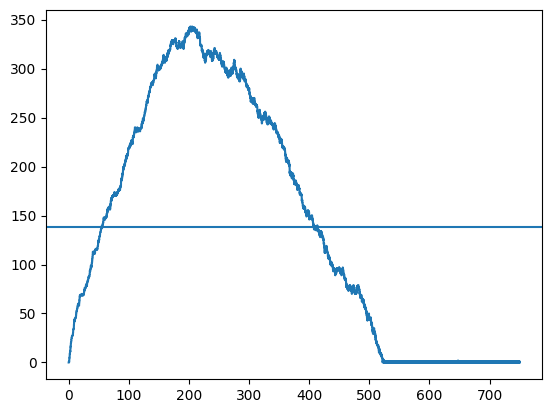

In [33]:
sim_result.num_waiting_over_time.plot()